Ran on Colab

# Introduction

This notebook will perform object detection (ships) on Satelital SAR images using YOLOv11 (the small version).

References with links:


*   Paper: [SAR Ship Detection Dataset (SSDD): Official Release and Comprehensive Data Analysis ](https://www.mdpi.com/2072-4292/13/18/3690)

*   Dataset: [Official-SSDD](https://github.com/TianwenZhang0825/Official-SSDD?tab=readme-ov-file)


*   Model / Tutorial: [Ultralytics](https://docs.ultralytics.com/tasks/detect/)

*   Labels convertion: Based on [this](https://haobin-tan.netlify.app/ai/computer-vision/object-detection/coco-json-to-yolo-txt/)



---

## First, lets check if our GPU is available:

In [ ]:
import torch
import tensorflow as tf

print('Is GPU available?', torch.cuda.is_available())

for i in range(torch.cuda.device_count()):
   print('GPU name:', torch.cuda.get_device_properties(i).name)

print("GPU disponível:", tf.config.list_physical_devices('GPU'))


Is GPU available? True
GPU name: Tesla T4
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---

## Set up:

In [ ]:
!pip install ultralytics unrar #for colab

In [ ]:
import os
from ultralytics import YOLO
import shutil
import json
from tqdm import tqdm

import matplotlib.pyplot as plt

---

## Obtaining the dataset

In [ ]:
!gdown 1glNJUGotrbEyk43twwB9556AdngJsynZ #obtaining the dataset - around 1 GB

Downloading...
From (original): https://drive.google.com/uc?id=1glNJUGotrbEyk43twwB9556AdngJsynZ
From (redirected): https://drive.google.com/uc?id=1glNJUGotrbEyk43twwB9556AdngJsynZ&confirm=t&uuid=016a257f-9348-4e32-ab2b-9e1132a9a7af
To: /content/Official-SSDD-OPEN.rar
100% 1.04G/1.04G [00:13<00:00, 75.6MB/s]


In [ ]:
!unrar x Official-SSDD-OPEN.rar #maybe the path must be changed for yout aplication

Streaming output truncated to the last 5000 lines.
Extracting  Official-SSDD-OPEN/RBox_SSDD/voc_style/Annotations_train/001028.xml      76%  OK 
Extracting  Official-SSDD-OPEN/RBox_SSDD/voc_style/Annotations_train/001030.xml      76%  OK 
Extracting  Official-SSDD-OPEN/RBox_SSDD/voc_style/Annotations_train/001032.xml      76%  OK 
Extracting  Official-SSDD-OPEN/RBox_SSDD/voc_style/Annotations_train/001033.xml      76%  OK 
Extracting  Official-SSDD-OPEN/RBox_SSDD/voc_style/Annotations_train/001034.xml      76%  OK 
Extracting  Official-SSDD-OPEN/RBox_SSDD/voc_style/Annotations_train/001035.xml      76%  OK 
Extracting  Official-SSDD-OPEN/RBox_SSDD/voc_style/Annotations_train/001036.xml      76%  OK 
Extracting  Official-SSDD-OPEN/RBox_SSDD/voc_style/Annotations_train/001037.xml      76%  OK 
Extracting  Official-SSDD-OPEN/RBox_SSDD/voc_style/Annotations_train/001038.xml      76%  OK 
Extracting  Official-S

---

## Now, lets organize our dataset according to the .yaml (YOLO) structure:

It must be something like this:

Path
  - train
    - images
      - img1.png
      - img2.png
      - ...
      - imgX.png
    - labels
      - lab1.txt
      - lab2.txt
      - ...
      - labX.txt

  - valid
    - images
      - img1.png
      - img2.png
      - ...
      - imgX.png
    - labels
      - lab1.txt
      - lab2.txt
      - ...
      - labX.txt

In [ ]:
folders = ['SSDD/train/images', 'SSDD/train/labels', 'SSDD/valid/images', 'SSDD/valid/labels']

In [ ]:
for path in folders:
  if not os.path.exists(path):
      # Create the directory
      os.makedirs(path)
      print(f"Directory '{path}' created")
  else:
      print(f"Directory '{path}' already exists")

Directory 'SSDD/train/images' already exists
Directory 'SSDD/train/labels' already exists
Directory 'SSDD/valid/images' already exists
Directory 'SSDD/valid/labels' already exists


---

## Now, we must obtain the .txt files from the .json files downloaded with the dataset.

In [ ]:
def convert_bbox_coco2yolo(img_width, img_height, bbox):
    x_tl, y_tl, w, h = bbox
    x_center = (x_tl + w / 2) / img_width
    y_center = (y_tl + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return [x_center, y_center, width, height]

def make_folders(path="output"):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def convert_coco_json_to_yolo_txt(output_path, json_file):
    path = make_folders(output_path)

    with open(json_file) as f:
        json_data = json.load(f)

    label_file = os.path.join(output_path, "_darknet.labels")
    with open(label_file, "w") as f:
        for category in tqdm(json_data["categories"], desc="Loading..."):
            category_name = category["name"]
            f.write(f"{category_name}\n")

    for image in tqdm(json_data["images"], desc="Creating annotation..."):
        img_id = image["id"]
        img_name = image["file_name"]
        img_width = image["width"]
        img_height = image["height"]

        anno_in_image = [anno for anno in json_data["annotations"] if anno["image_id"] == img_id]
        anno_txt = os.path.join(output_path, img_name.split(".")[0] + ".txt")
        with open(anno_txt, "w") as f:
            for anno in anno_in_image:
                category_id = anno["category_id"]
                bbox_COCO = anno["bbox"]
                x_center, y_center, width, height = convert_bbox_coco2yolo(img_width, img_height, bbox_COCO)
                f.write(f"{category_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
    print("Done!")

In [ ]:
convert_coco_json_to_yolo_txt('SSDD/train/labels', 'Official-SSDD-OPEN/BBox_SSDD/coco_style/annotations/train.json')
convert_coco_json_to_yolo_txt('SSDD/valid/labels', 'Official-SSDD-OPEN/BBox_SSDD/coco_style/annotations/test.json')

Creating annotation...: 100%|██████████| 928/928 [00:00<00:00, 4768.67it/s]


Done!


Creating annotation...: 100%|██████████| 232/232 [00:00<00:00, 10985.93it/s]

Done!


## Creating the final directories

In [ ]:
list_train = os.listdir('/content/Official-SSDD-OPEN/BBox_SSDD/coco_style/images/train')
list_valid = os.listdir('/content/Official-SSDD-OPEN/BBox_SSDD/coco_style/images/test')

for filename in list_train:
  new_path = os.path.join('SSDD/train/images', filename)
  old_path = os.path.join('/content/Official-SSDD-OPEN/BBox_SSDD/coco_style/images/train', filename)
  shutil.move(old_path, new_path)

for filename in list_valid:
  new_path = os.path.join('SSDD/valid/images', filename)
  old_path = os.path.join('/content/Official-SSDD-OPEN/BBox_SSDD/coco_style/images/test', filename)
  shutil.move(old_path, new_path)

---

## Yolo needs (at least the way its being used here) a .yaml file with the paths for the images, labels and classes.

The following code will create this file for this application

In [ ]:
with open ("ssdd.yaml", "w") as f:
  f.write("path: /content/SSDD \ntrain: train/images \nval: valid/images \nnames: \n  0: ship")

---

## Defining the model

We are using the "small" variant here. We've chosen this one for the following reasons:
- It is not so small. The "nano" version could be chosen, but our dataset has around 1k images, so a sligthly bigger model can be necessary for better convertion;

- The usage of Free Colab here... so our usage and memmory are both limited. Also, we have to be aware with being kicked out and loose everything (checkpoints could be used too);

- It is necessary to wait for the training to finish and a bigger model ("architecture" or "variant") will take longer due to the increase of params.

In [ ]:
model = YOLO("yolo11s.pt")

## Training

We've set some parameters to "0" because they do not make sense when applied to monochromatic images.
Almost all of them are commented bellow:

In [ ]:
history = model.train(data = 'ssdd.yaml',
                      epochs = 50,
                      imgsz = 320, #here we have a little problem 'cause our images don't follow a specific shape for height and width... the closest we can get is 320x320 which would perform less deformations. This parameter can affect model accuracy - look ate Ultralytics page)
                      batch = -1, # batch size defined dinamically
                      cache = True,
                      cos_lr = True, #better convergence and avoid getting stuck
                      patience = 20,
                      hsv_h = 0, # described above
                      hsv_s = 0, # described above
                      hsv_v = 0, # described above
                      mixup = 0.5,
                      erasing = 0.2, # reducing the ratio to avoid cropping whole targets
                      )

Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=ssdd.yaml, epochs=50, time=None, patience=20, batch=-1, imgsz=320, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=N

train: Scanning /content/SSDD/train/labels... 928 images, 0 backgrounds, 0 corrupt: 100%|██████████| 928/928 [00:00<00:00, 2020.41it/s]

train: New cache created: /content/SSDD/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 928/928 [00:02<00:00, 429.78it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=320 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.14G reserved, 0.11G allocated, 14.49G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


     9428179       5.387         0.614          83.2         574.6        (1, 3, 320, 320)                    list
     9428179       10.77         0.734         42.12         150.5        (2, 3, 320, 320)                    list
     9428179       21.55         0.877         33.99         119.5        (4, 3, 320, 320)                    list
     9428179        43.1         1.221         36.29         121.2        (8, 3, 320, 320)                    list
     9428179       86.19         1.795         38.69         116.8       (16, 3, 320, 320)                    list
AutoBatch: WARNING ⚠️ batch=1227 outside safe range, using default batch-size 16.
AutoBatch: Using batch-size 16 for CUDA:0 1.90G/14.74G (13%) ✅


train: Scanning /content/SSDD/train/labels.cache... 928 images, 0 backgrounds, 0 corrupt: 100%|██████████| 928/928 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.2GB RAM): 100%|██████████| 928/928 [00:01<00:00, 605.38it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/SSDD/valid/labels... 232 images, 0 backgrounds, 0 corrupt: 100%|██████████| 232/232 [00:00<00:00, 1438.35it/s]

val: New cache created: /content/SSDD/valid/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 232/232 [00:00<00:00, 476.36it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.41G      1.617       1.66     0.9612        204        320: 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


                   all        232        546      0.387      0.518      0.344      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.33G      1.444     0.9108     0.9149        195        320: 100%|██████████| 58/58 [00:10<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        232        546     0.0362       0.41     0.0246     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.34G      1.468     0.8726     0.9127        178        320: 100%|██████████| 58/58 [00:09<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]

                   all        232        546      0.708      0.645      0.688      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.32G      1.444     0.8126     0.9121        125        320: 100%|██████████| 58/58 [00:11<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]

                   all        232        546      0.734      0.668      0.714      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.33G      1.418     0.8361     0.9083        201        320: 100%|██████████| 58/58 [00:11<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.27it/s]

                   all        232        546      0.812      0.616      0.725      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.33G      1.343     0.7561     0.8951        153        320: 100%|██████████| 58/58 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]

                   all        232        546      0.715      0.647      0.706      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.33G       1.38     0.7695     0.9001        148        320: 100%|██████████| 58/58 [00:09<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.86it/s]

                   all        232        546      0.758      0.711      0.773      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.34G      1.322     0.7631     0.8997        204        320: 100%|██████████| 58/58 [00:11<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.15it/s]

                   all        232        546      0.792      0.734      0.801      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.33G      1.322     0.7427     0.8968        212        320: 100%|██████████| 58/58 [00:11<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]

                   all        232        546      0.793      0.685      0.779      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.34G      1.279     0.7196     0.8932        182        320: 100%|██████████| 58/58 [00:10<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]

                   all        232        546        0.9      0.692      0.822      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.33G      1.237      0.701     0.8811        146        320: 100%|██████████| 58/58 [00:09<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]

                   all        232        546      0.842      0.721      0.823      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.33G      1.288     0.7127     0.8839        141        320: 100%|██████████| 58/58 [00:10<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.25it/s]

                   all        232        546      0.828      0.707      0.787      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.35G      1.248     0.6947     0.8834        180        320: 100%|██████████| 58/58 [00:11<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]

                   all        232        546      0.784      0.744      0.823      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.34G      1.206     0.6569     0.8742        174        320: 100%|██████████| 58/58 [00:11<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]

                   all        232        546      0.855      0.732      0.846       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.32G       1.18     0.6598     0.8703        183        320: 100%|██████████| 58/58 [00:09<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]

                   all        232        546      0.825       0.76      0.844       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.34G      1.192     0.6523     0.8789        121        320: 100%|██████████| 58/58 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.13it/s]

                   all        232        546       0.82      0.731       0.81      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       1.3G        1.2     0.6461     0.8705        188        320: 100%|██████████| 58/58 [00:11<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.19it/s]

                   all        232        546      0.897      0.762      0.857      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.34G      1.192     0.6409     0.8787        166        320: 100%|██████████| 58/58 [00:11<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]

                   all        232        546      0.935      0.764       0.88      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.33G       1.18     0.6366      0.868        187        320: 100%|██████████| 58/58 [00:09<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]

                   all        232        546      0.918      0.758      0.881      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.34G      1.163      0.624      0.863        181        320: 100%|██████████| 58/58 [00:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]

                   all        232        546       0.86      0.725      0.844      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.33G      1.159     0.6364     0.8746        132        320: 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]

                   all        232        546      0.868      0.761      0.872      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.34G       1.14     0.6128     0.8621        140        320: 100%|██████████| 58/58 [00:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

                   all        232        546      0.895      0.799      0.893      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.34G      1.121      0.599     0.8689        182        320: 100%|██████████| 58/58 [00:09<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]

                   all        232        546      0.908      0.819      0.897      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.34G      1.127      0.598     0.8611        173        320: 100%|██████████| 58/58 [00:10<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.35it/s]

                   all        232        546      0.899      0.717      0.823      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.31G      1.111     0.6059     0.8619        262        320: 100%|██████████| 58/58 [00:11<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]

                   all        232        546      0.889      0.804      0.903      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.35G      1.104     0.5961      0.858        174        320: 100%|██████████| 58/58 [00:11<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]

                   all        232        546       0.92       0.78      0.887      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.31G      1.093     0.5825     0.8624        172        320: 100%|██████████| 58/58 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]

                   all        232        546      0.896       0.77      0.871      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.35G      1.069     0.5697     0.8551        208        320: 100%|██████████| 58/58 [00:09<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.35it/s]

                   all        232        546      0.864      0.799      0.883      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.31G      1.066     0.5546     0.8578        193        320: 100%|██████████| 58/58 [00:11<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.13it/s]

                   all        232        546      0.915      0.811      0.902      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.34G      1.056     0.5596     0.8562        166        320: 100%|██████████| 58/58 [00:11<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.36it/s]

                   all        232        546      0.924      0.798      0.917      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.34G      1.041     0.5515     0.8488        135        320: 100%|██████████| 58/58 [00:10<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]

                   all        232        546      0.917      0.793      0.912      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.34G      1.045      0.558     0.8522        134        320: 100%|██████████| 58/58 [00:09<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all        232        546      0.863       0.82      0.903      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.35G      1.049     0.5534     0.8561        218        320: 100%|██████████| 58/58 [00:10<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]

                   all        232        546      0.907      0.824      0.915      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.34G      1.009     0.5278     0.8432        153        320: 100%|██████████| 58/58 [00:11<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.16it/s]

                   all        232        546      0.894      0.835      0.916      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.33G      1.017      0.535      0.847        185        320: 100%|██████████| 58/58 [00:11<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.45it/s]

                   all        232        546      0.915      0.833      0.919      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.34G     0.9834      0.519     0.8416        146        320: 100%|██████████| 58/58 [00:09<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.85it/s]

                   all        232        546      0.871      0.817      0.894      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.33G      0.995     0.5198     0.8518        134        320: 100%|██████████| 58/58 [00:10<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.28it/s]

                   all        232        546      0.889      0.811      0.901      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.32G     0.9867     0.5106     0.8447        165        320: 100%|██████████| 58/58 [00:11<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]

                   all        232        546       0.91      0.821      0.908      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.33G     0.9791     0.5033     0.8389        143        320: 100%|██████████| 58/58 [00:11<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]

                   all        232        546      0.905      0.821      0.911      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.32G       0.97     0.5037     0.8447        144        320: 100%|██████████| 58/58 [00:10<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]

                   all        232        546      0.909      0.843      0.922      0.634


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.31G       1.09     0.7093     0.9986         25        320: 100%|██████████| 58/58 [00:08<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]

                   all        232        546      0.901      0.814      0.907      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.33G      1.076     0.6028     0.9846         44        320: 100%|██████████| 58/58 [00:09<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]

                   all        232        546      0.897      0.844      0.923      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.34G      1.028     0.5739     0.9613         33        320: 100%|██████████| 58/58 [00:10<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]

                   all        232        546      0.906      0.853      0.933      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.32G       1.02     0.5692     0.9659         30        320: 100%|██████████| 58/58 [00:08<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]

                   all        232        546      0.939       0.85      0.945       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.34G      1.031     0.5585     0.9661         31        320: 100%|██████████| 58/58 [00:08<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.43it/s]

                   all        232        546      0.927      0.842      0.939      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.33G      0.993     0.5478     0.9625         26        320: 100%|██████████| 58/58 [00:10<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.40it/s]

                   all        232        546      0.923       0.86       0.95      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.34G     0.9795     0.5368     0.9478         41        320: 100%|██████████| 58/58 [00:09<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        232        546      0.942      0.862      0.948      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.32G     0.9803     0.5375     0.9547         48        320: 100%|██████████| 58/58 [00:08<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.99it/s]

                   all        232        546      0.929      0.866      0.947      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.34G     0.9618      0.519      0.946         30        320: 100%|██████████| 58/58 [00:10<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.36it/s]

                   all        232        546      0.944      0.853      0.948      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.32G     0.9628     0.5266     0.9449         29        320: 100%|██████████| 58/58 [00:10<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.42it/s]

                   all        232        546      0.938      0.862      0.949      0.678



50 epochs completed in 0.181 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 19.1MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 19.1MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]


                   all        232        546      0.923       0.86       0.95      0.679
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train2


---

## Results

First, check out the type of the variable created by the training:

In [ ]:
type(history)

ultralytics.utils.metrics.DetMetrics

## Saving the .zip file

When the training is over, a folder is created to store every result of it. We saved and downloaded it.

It is available on the same Git as this notebook.

In [ ]:
shutil.make_archive('/content/train', 'zip', '/content/runs/detect/train')

'/content/train.zip'

## Graphics and confusion matrix

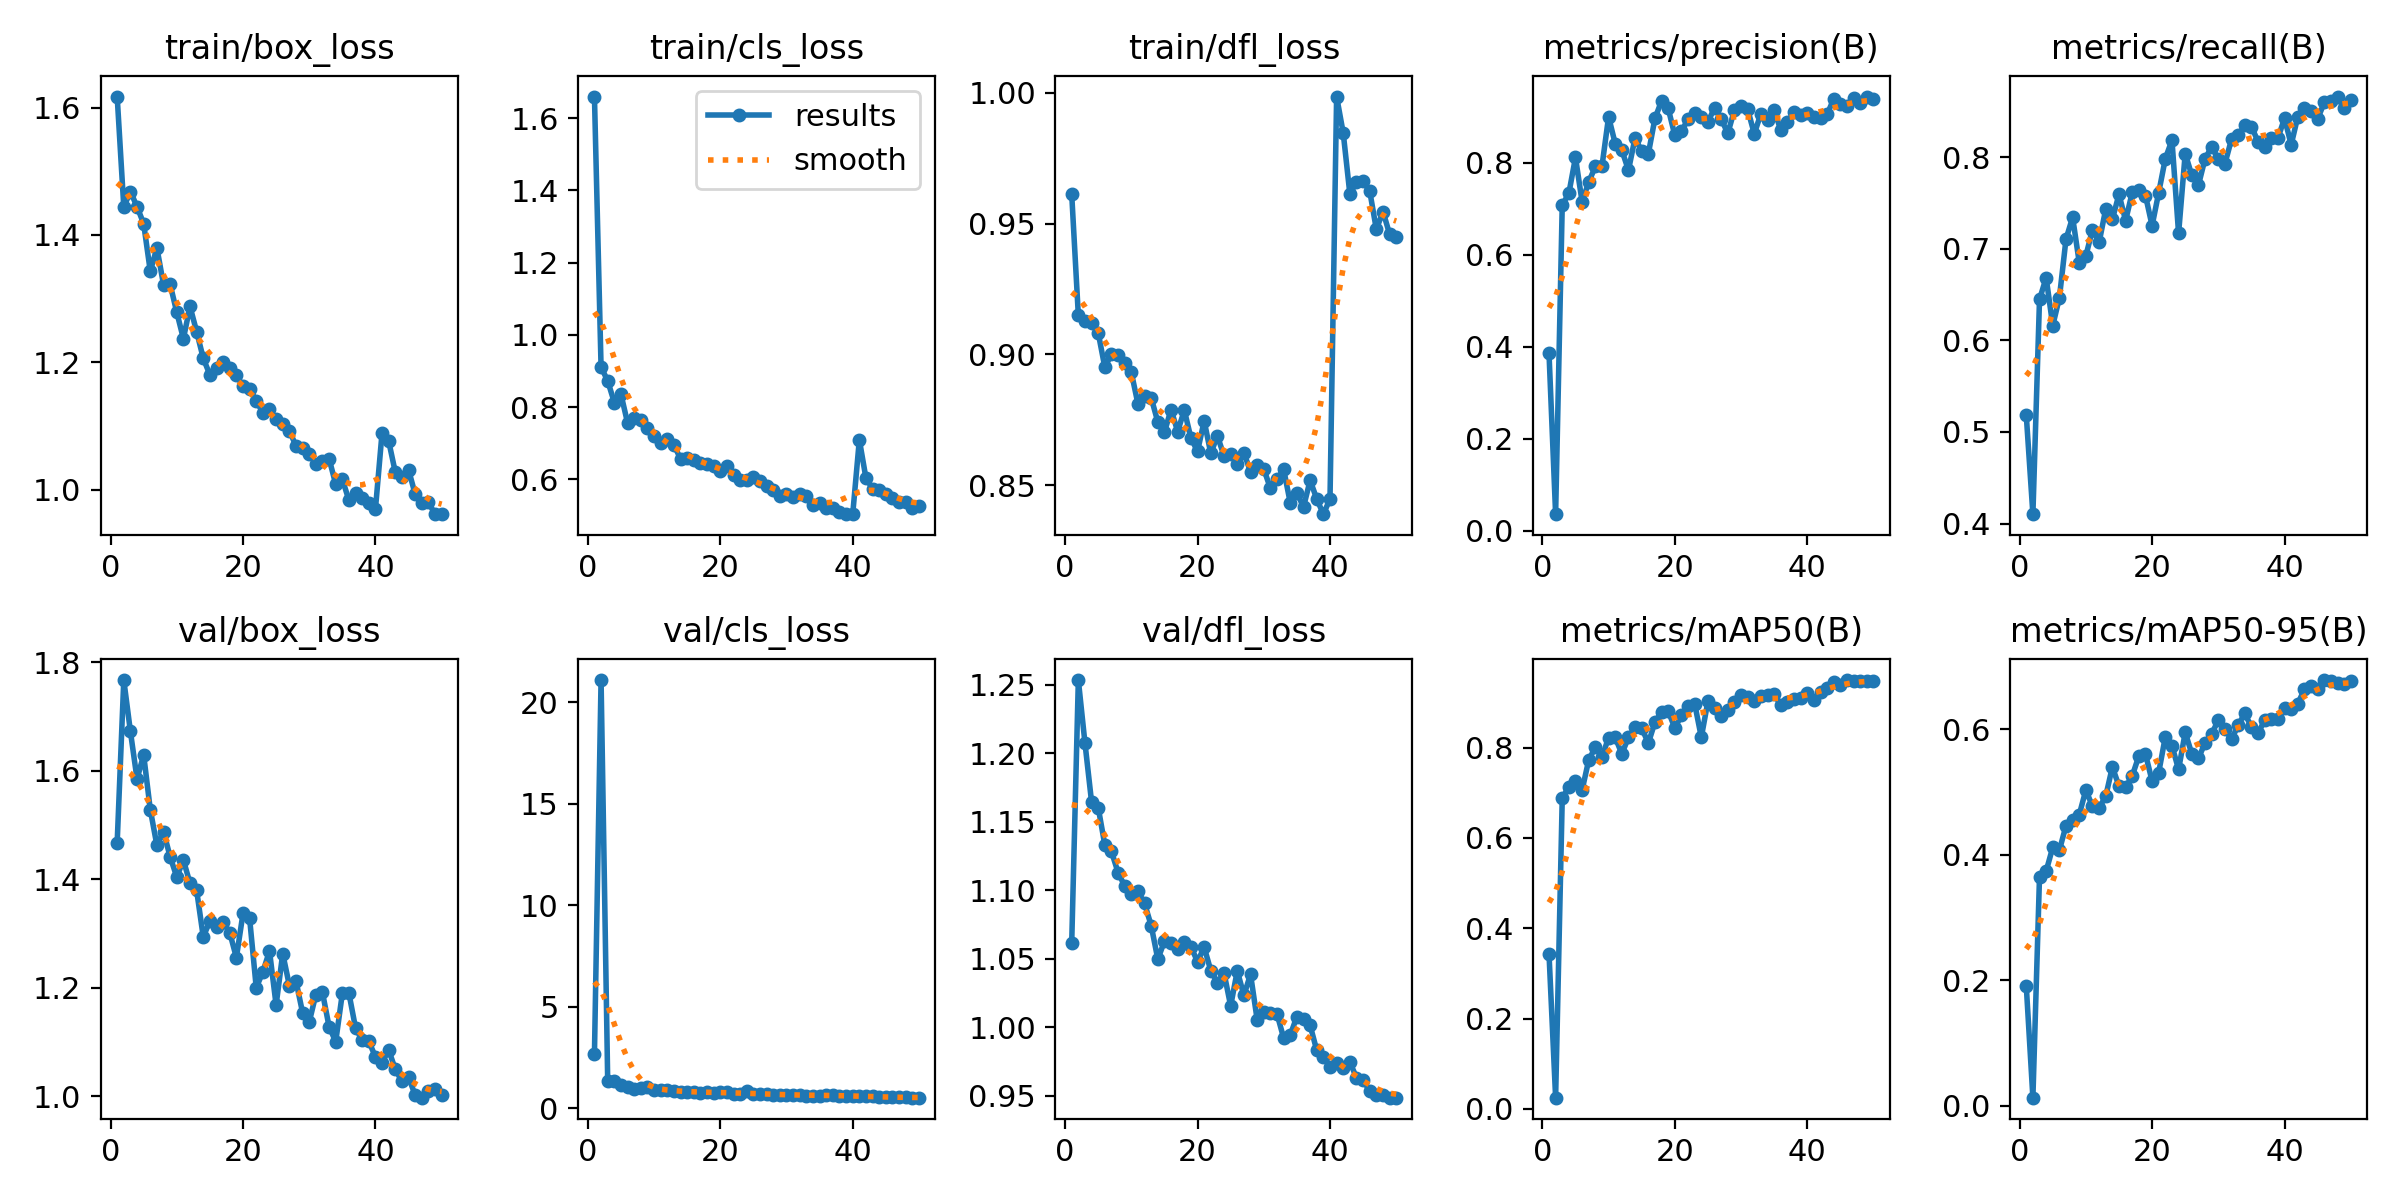

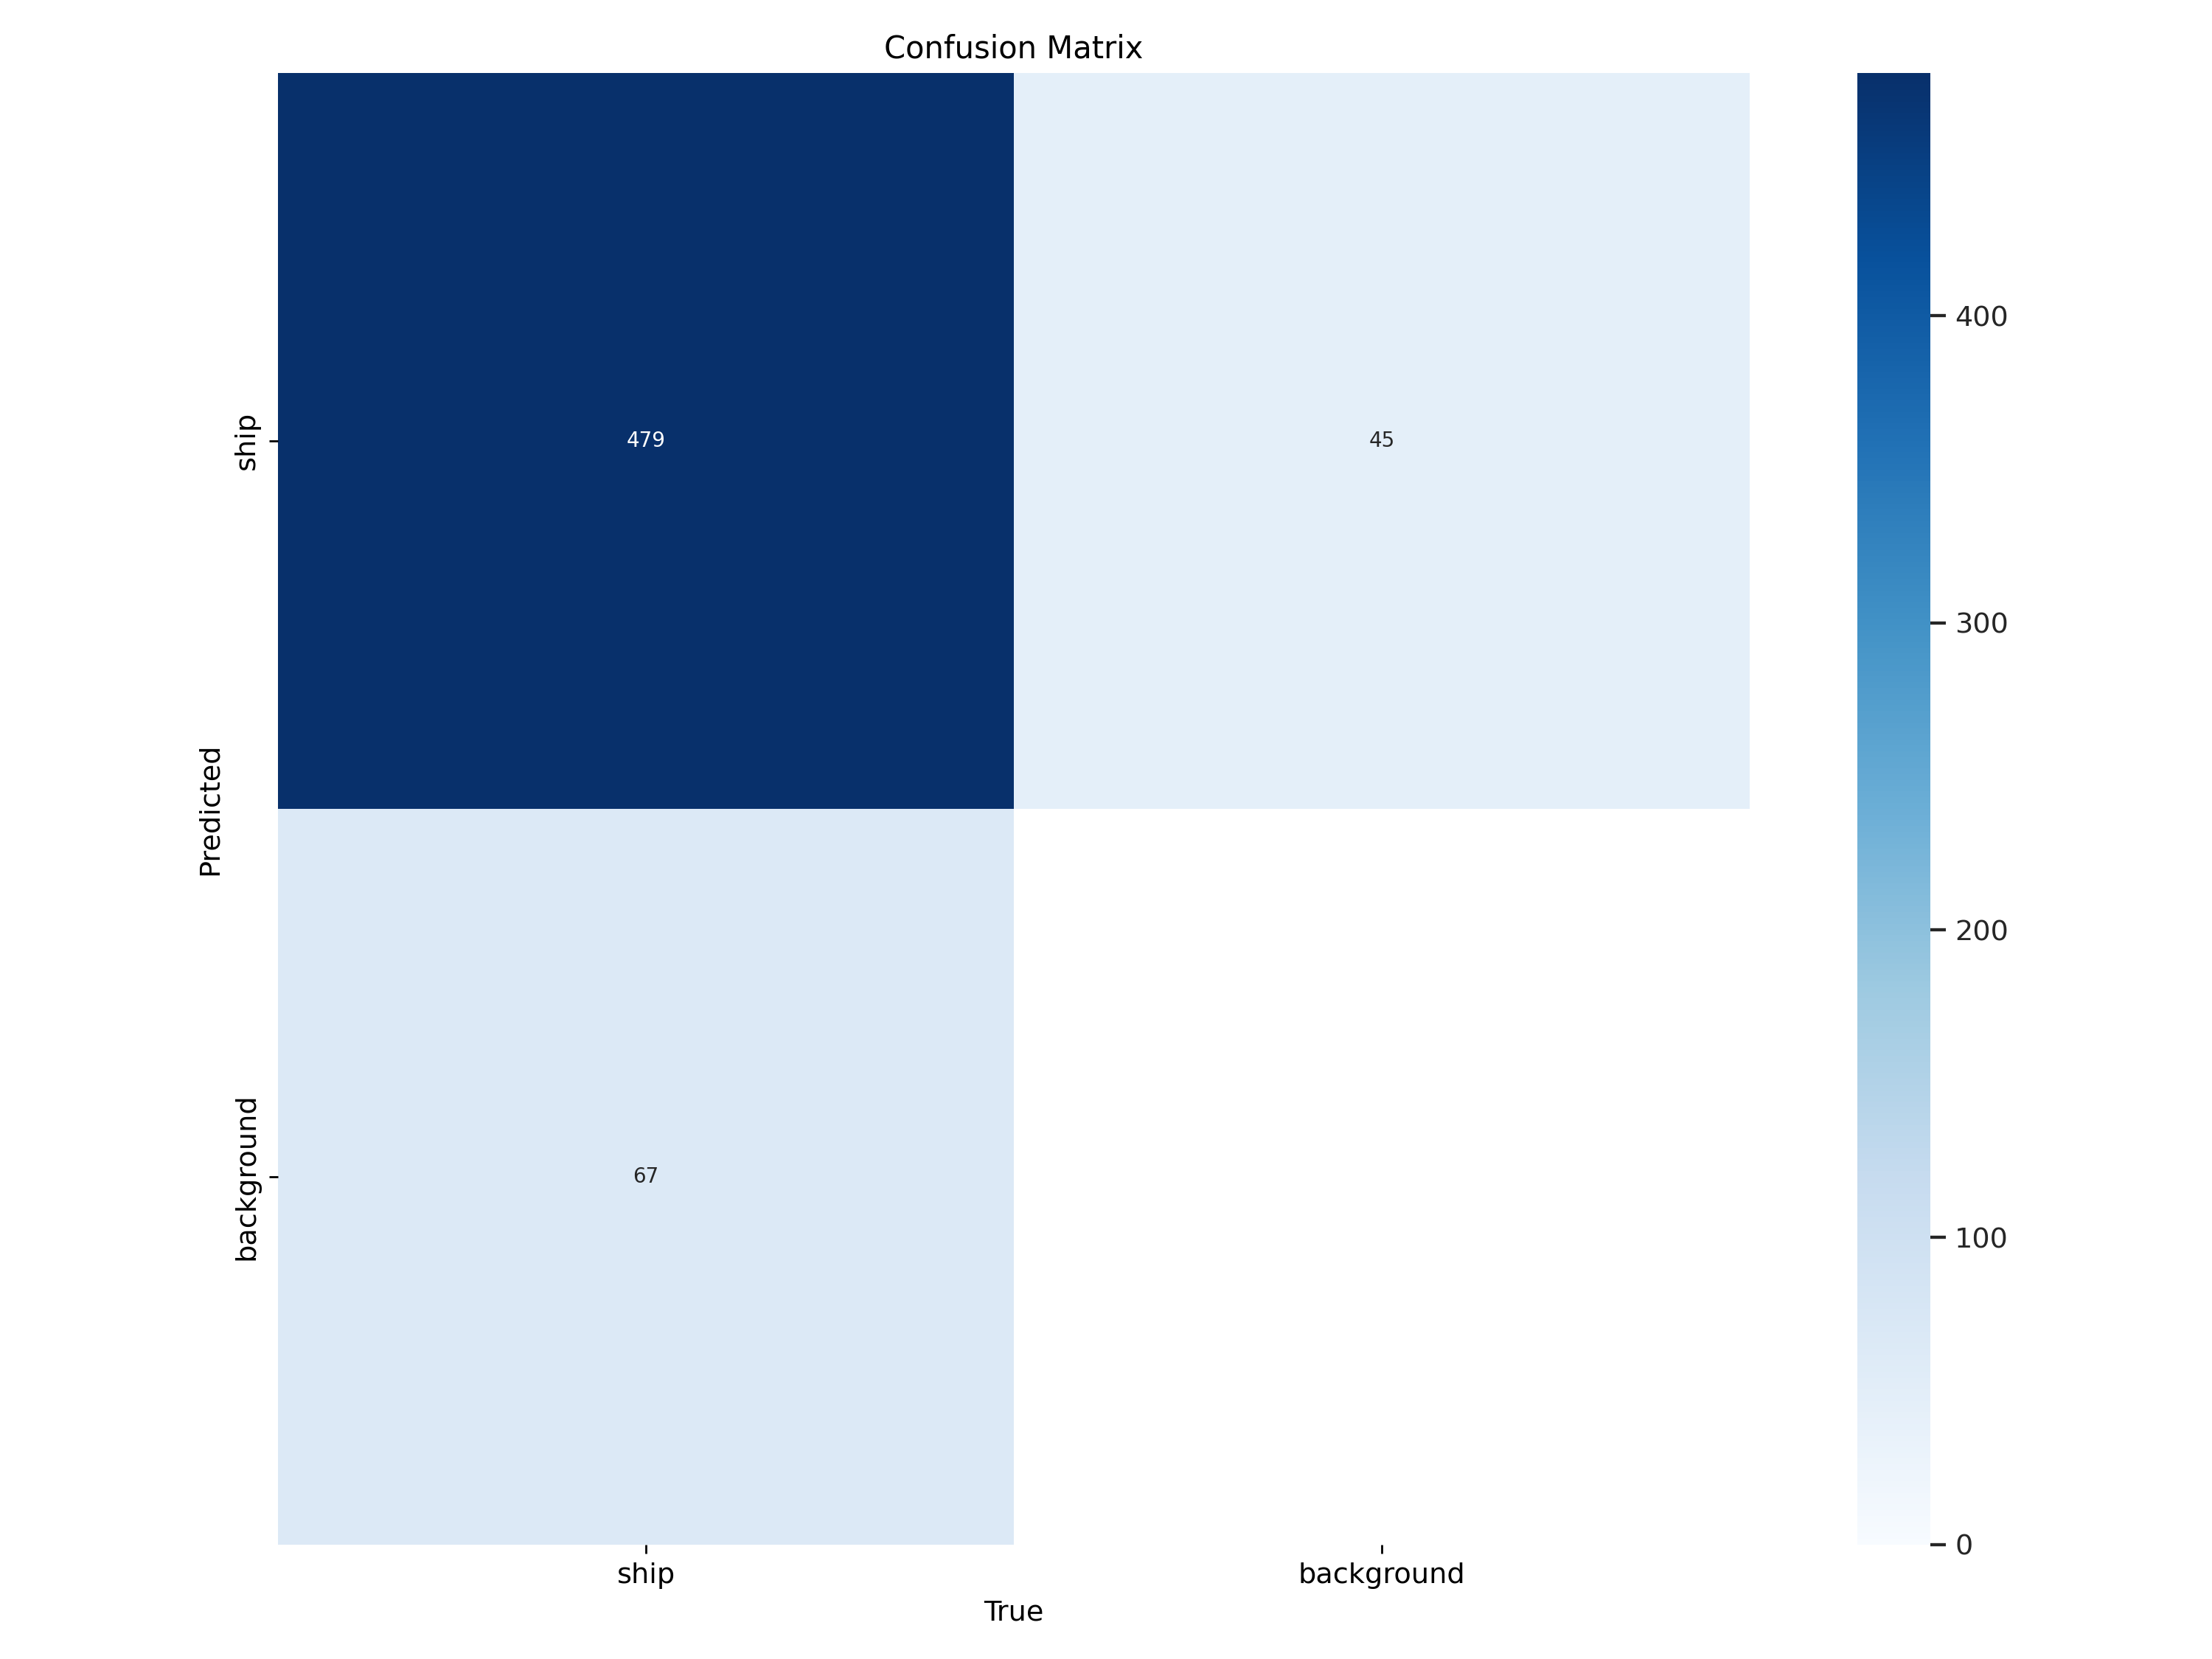

Looking at the graphics, we can see that the training could lasted for more epochs. The lines were not horizontal yet, so there is space for further improvemente... we've stopped here because our purpose is not to reach maximum performance, but to illustrate the usage of YOLO.

We can also see that our performance, as far as recall and precision, were improving and were also above 80%.

From our confusion matrix, see that our model were still making some mistakes (False Positives and False Negatives). The majority of the ships were being detected.